In [1]:
import numpy as np 
import torch 
from torch.utils.data import Dataset
from simulator import FSE_signal_TR
from tqdm import tqdm 
from matplotlib import pyplot as plt 

T = 32 
TE = 9 
TR = 2800
T2_init = 200.
device = torch.device('cuda')
dtype = torch.float32
batch_size = 1
num_epochs = 500
that_hat_init_angle = 125.
step_size_init_val = 10000.

In [2]:
def pbnet(y_meas, theta_hat, step_size, TE, TR, T1, testFlag=True):
    myt2 = torch.ones((batch_size), dtype=torch.float32, requires_grad=True, device=theta_hat.device)*T2_init
    if testFlag: y_meas = y_meas.detach()
    plt.plot(y_meas.cpu().numpy());
    sig_est = None 
    loss = None
    for kk in range(num_epochs):
        sig_est = FSE_signal_TR(theta_hat, TE, TR, T1, myt2, B1=1.).squeeze()
        rho_est = torch.sum(y_meas * sig_est) / torch.sum(sig_est * sig_est)
        sig_est = rho_est * sig_est
        residual = y_meas - sig_est
        loss = torch.sum(residual**2)
        
        g = torch.autograd.grad(loss, 
                                myt2, 
                                create_graph = not testFlag)[0]
        
        myt2 = myt2 - step_size*g           # gradient update
#         print(loss, myt2, g)
    return myt2, sig_est, loss

100%|██████████| 12/12 [07:29<00:00, 37.46s/it]

101.36363636363637



/home/ubuntu/miniconda3/envs/code/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later


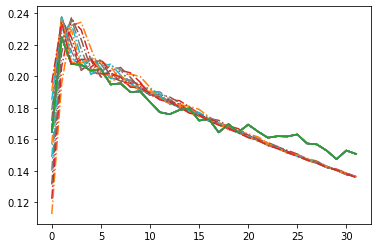

In [3]:
brain = np.abs(np.load('data/image.npy'))
data = brain[144, 144, 0, :]
# data = brain[110, 110, 0, :]

plt.figure()

losses = []
flip_angles = np.linspace(60, 125, 12)

for that_hat_init_angle in tqdm(flip_angles):
    final_theta = np.ones((1, T))*that_hat_init_angle
    theta_hat_init =  torch.tensor(
                final_theta/180*np.pi, dtype=torch.float32).to(device)
    theta_hat = theta_hat_init.detach().clone()
    myt2_init = torch.ones((batch_size), dtype=torch.float32, requires_grad=True, device=device)*T2_init

    step_size_init = torch.tensor([step_size_init_val], dtype=torch.float32).to(device)
    step_size = step_size_init.detach().clone()

    y = torch.tensor(data, dtype=torch.float32)
    T1 = torch.tensor(np.ones(batch_size)*1000., dtype=torch.float32)
    myt2_0 = myt2_init.detach().clone().to(device)
    t1 = T1.to(device)
    y_meas = y.to(device)
    y_meas = y_meas / torch.norm(y_meas)
    myt2, y_est, loss = pbnet(y_meas, theta_hat, step_size, TE, TR, t1, testFlag=True)
    losses.append(loss.detach().cpu().numpy().tolist())
    plt.plot(y_est.detach().cpu().numpy(), linestyle='dashdot')
plt.savefig('Fig 4a - signal-144.png', bbox_to_inches='tight')
min_loss_idx = np.argmin(losses)
best_flip_angle = flip_angles[min_loss_idx]
print(best_flip_angle)

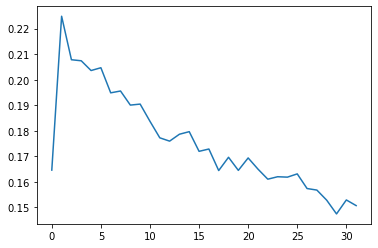

In [6]:
y_meas = brain[144, 144, 0, :]
y_meas = y_meas / np.linalg.norm(y_meas)
plt.figure()
plt.plot(y_meas)